In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType


In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Combine CSV Files") \
    .getOrCreate()


file_paths = [
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00000-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00001-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00002-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00003-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00004-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00005-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00006-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00007-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00008-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv"
]


dataframes = [spark.read.csv(file, header=True, inferSchema=True) for file in file_paths]


df = dataframes[0]
for df in dataframes[1:]:
    df = df.union(df)


df.show()


24/12/10 14:57:03 WARN Utils: Your hostname, Elviss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.57 instead (on interface en0)
24/12/10 14:57:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 14:57:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/10 14:57:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/10 14:58:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-----+-----------------+----------+--------+-------------------+-------------------+---------+------------------+------------------+--------------------+--------------+-----------+------------+--------------+--------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+-----------+-----------+----+----+------------------+
|State|Month|Weather_Condition|    County|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|      Distance(mi)|                City|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Civil_Twilight|Day_of_Week|Day_of_Year|Year|Hour|  Traffic_Duration|
+-----+-----+-----------------+----------+--------+-------------------+-------

+--------+------+
|Severity| count|
+--------+------+
|       2|361104|
|       3|101296|
|       4| 81382|
+--------+------+



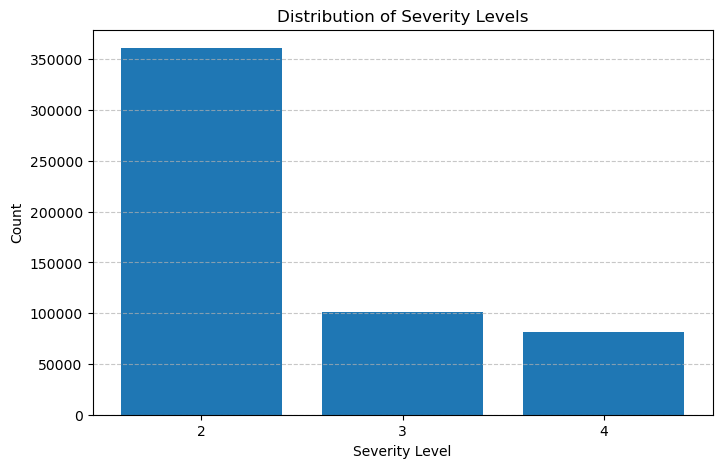

In [3]:
from pyspark.sql import functions as F

# Count the distribution of Severity
severity_distribution = df.groupBy("Severity").count().orderBy("Severity")

# Show the distribution
severity_distribution.show()

# Convert to Pandas for visualization
severity_pandas = severity_distribution.toPandas()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(severity_pandas['Severity'], severity_pandas['count'], tick_label=severity_pandas['Severity'])
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [4]:
from pyspark.sql import functions as F

# Reclassify classes (merge classes 3 and 4 into class 3)
df = df.withColumn('Severity', F.when(df['Severity'] == 4, 3).otherwise(df['Severity']))

# Check the class distribution after merging
severity_distribution = df.groupBy("Severity").count().orderBy("Severity")
severity_distribution.show()


+--------+------+
|Severity| count|
+--------+------+
|       2|361104|
|       3|182678|
+--------+------+



In [5]:
feature_columns = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Traffic_Duration', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
    'Traffic_Signal', 'Civil_Twilight'
]


In [7]:
# Identify categorical features
categorical_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight'
]

# Identify numerical features (rest of the columns)
numerical_features = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Traffic_Duration'
]


In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


# Step 1: Assemble numerical features into a single vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
df = assembler.transform(df)

# Step 2: Normalize the features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Step 3: View the normalized features
df.select("scaled_features").show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.44952567376578884,1.1874784995404355,-0.258015177571466,-1.7619069225349875,-0.35399684835904305,-0.30303419433830137,0.20157803299798782,-0.33310526076141483,-0.051169878602791624,0.005762433493609487]|
|[0.4380145048239234,1.1828932839011006,-0.40725940825460605,-1.4890666790636622,0.08037507711605565,-0.33199465443980564,0.20157803299798782,0.31989691523872654,-0.051

In [11]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType

# Ensure all BooleanType columns are cast to StringType
for col in categorical_features:
    if dict(df.dtypes)[col] == "boolean":
        df = df.withColumn(col, F.col(col).cast(StringType()))

# Step 1: StringIndexer for each categorical feature
# Temporarily write to new columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_temp") 
    for col in categorical_features
]

# Step 2: Create a pipeline for StringIndexing
pipeline = Pipeline(stages=indexers)
df_temp = pipeline.fit(df).transform(df)

# Step 3: Overwrite original columns with the indexed ones
for col in categorical_features:
    df_temp = df_temp.drop(col).withColumnRenamed(f"{col}_temp", col)

# Step 4: Combine numerical and encoded categorical features into 'final_features'
assembler = VectorAssembler(
    inputCols=numerical_features + categorical_features, 
    outputCol="final_features"
)

df_prepared = assembler.transform(df_temp)

# Step 5: View the resulting DataFrame
df_prepared.select("final_features", "Severity").show(5, truncate=False)


+------------------------------------------------------------------------------------------------+--------+
|final_features                                                                                  |Severity|
+------------------------------------------------------------------------------------------------+--------+
|(23,[0,1,2,3,4,5,6,7,9],[40.06695,-75.66226999999998,0.253,32.0,55.0,29.4,10.0,7.0,360.0])      |2       |
|(23,[0,1,3,4,5,6,7,9,21],[40.00663,-75.7461,37.0,65.0,29.37,10.0,10.0,30.0,1.0])                |2       |
|(23,[0,1,3,4,5,6,7,9,21],[40.00663,-75.7461,37.0,65.0,29.37,10.0,10.0,30.0,1.0])                |2       |
|(23,[0,1,2,3,4,5,6,7,9],[40.15868,-77.69886,4.579,25.0,39.0,30.51,10.0,9.2,360.0])              |2       |
|(23,[0,1,2,3,4,5,6,7,9],[40.11231,-75.27999,0.398,32.0,55.0,30.13,10.0,9.220321336978788,360.0])|2       |
+------------------------------------------------------------------------------------------------+--------+
only showing top 5 rows



In [10]:
df_prepared.printSchema()

root
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Turning_Loop: boolean (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Day_of_Year: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Traffic_D

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split data into training and testing sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

# Train Logistic Regression
lr = LogisticRegression(featuresCol="final_features", labelCol="Severity", maxIter=10)
lr_model = lr.fit(train_data)

# Make predictions on test set
predictions = lr_model.transform(test_data)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test set accuracy: {accuracy}")


24/12/10 15:10:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test set accuracy: 0.689030018831001


In [15]:
# Generate Confusion Matrix
confusion_matrix = predictions.groupBy("Severity", "prediction").count().orderBy("Severity", "prediction")
confusion_matrix.show()


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0|98640|
|       2|       3.0| 8949|
|       3|       2.0|41583|
|       3|       3.0|13326|
+--------+----------+-----+



In [18]:
# Confusion Matrix calculation
confusion_matrix = (
    predictions.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Convert Confusion Matrix to Pandas DataFrame
confusion_matrix_df = confusion_matrix.toPandas()

# Pivot the data for a matrix-like structure
pivot_table = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)


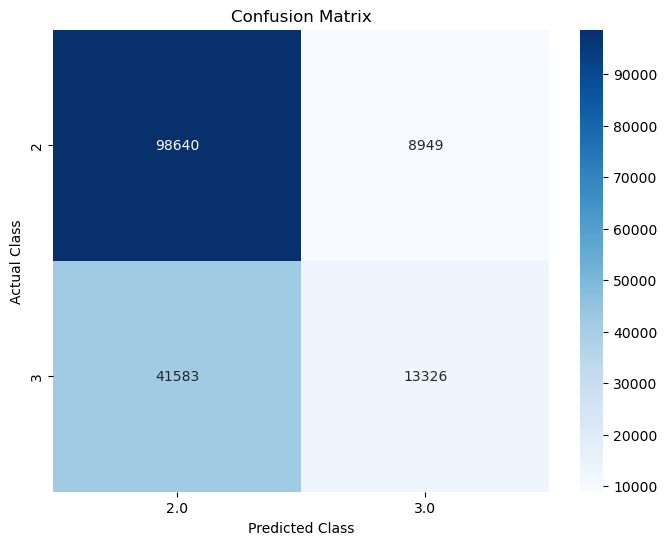

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="g", cmap="Blues")

# Add titles and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


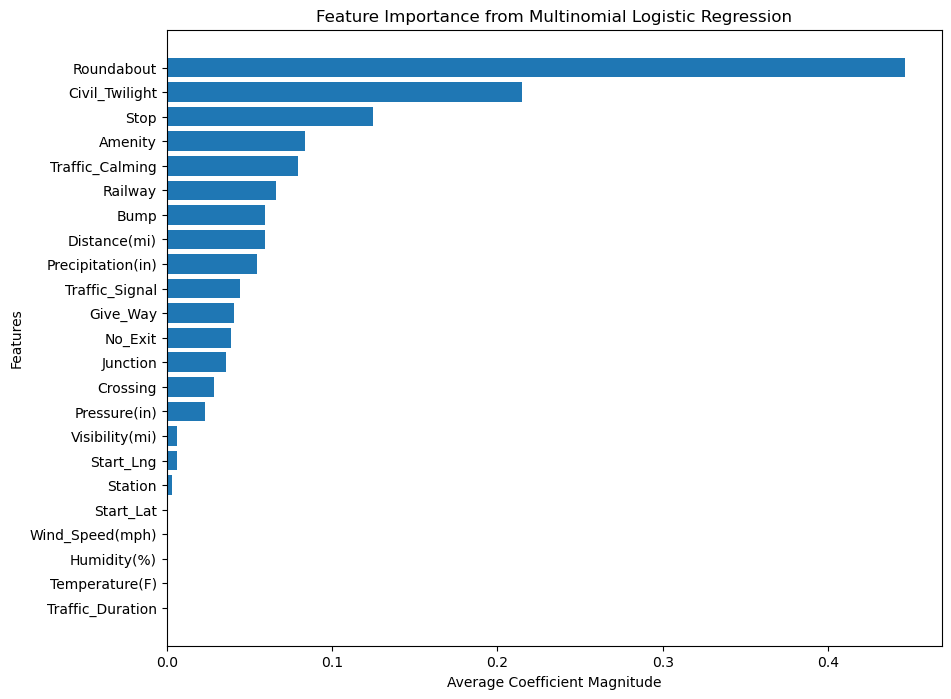

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract the coefficient matrix for multinomial logistic regression
coefficient_matrix = lr_model.coefficientMatrix.toArray()

# Compute the average absolute importance across all classes
average_importance = np.mean(np.abs(coefficient_matrix), axis=0)

# Map coefficients to feature names
feature_columns = numerical_features + categorical_features
feature_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": average_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.title("Feature Importance from Multinomial Logistic Regression")
plt.xlabel("Average Coefficient Magnitude")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


### Oversampling

In [20]:
# Oversample the minority class (Severity=3)
minority_class = df_prepared.filter(F.col("Severity") == 3)
majority_class = df_prepared.filter(F.col("Severity") == 2)

# Compute oversampling fraction
oversample_fraction = majority_class.count() / minority_class.count()

# Oversample the minority class
oversampled_minority = minority_class.sample(withReplacement=True, fraction=oversample_fraction, seed=42)

# Combine majority and oversampled minority class
df_over = majority_class.union(oversampled_minority)

# Verify the new class distribution
df_over.groupBy("Severity").count().show()


+--------+------+
|Severity| count|
+--------+------+
|       2|361104|
|       3|360603|
+--------+------+



In [21]:
# Split oversampled dataset into train/test sets
train_over, test_over = df_over.randomSplit([0.7, 0.3], seed=42)


In [22]:
from pyspark.ml.classification import LogisticRegression

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="final_features", labelCol="Severity", maxIter=10)
lr_model_over = lr.fit(train_over)

# Make predictions on test set
predict_over = lr_model_over.transform(test_over)


In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy_over = evaluator.evaluate(predict_over)

print(f"Accuracy (Oversampled): {accuracy_over}")

# Generate Confusion Matrix
confusion_matrix_over = (
    predict_over.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Display Confusion Matrix
confusion_matrix_over.show()


Accuracy (Oversampled): 0.611764597387387


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0|66321|
|       2|       3.0|41682|
|       3|       2.0|42515|
|       3|       3.0|66353|
+--------+----------+-----+



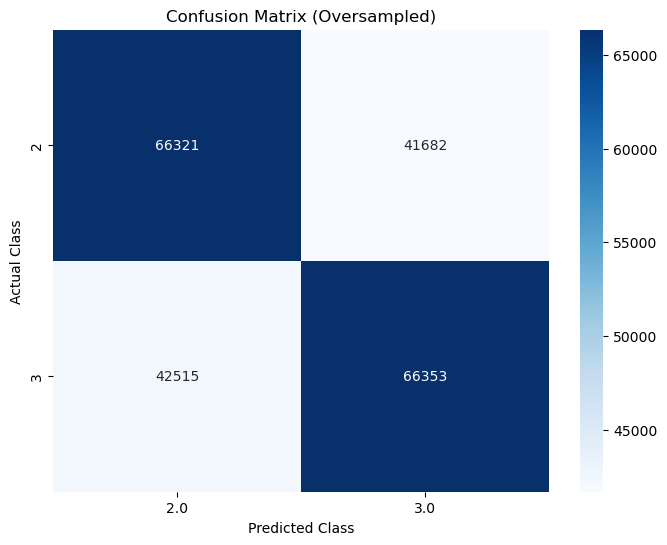

In [24]:
# Convert Confusion Matrix to Pandas
confusion_matrix_over_df = confusion_matrix_over.toPandas()

# Pivot for heatmap
pivot_over = confusion_matrix_over_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_over, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix (Oversampled)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


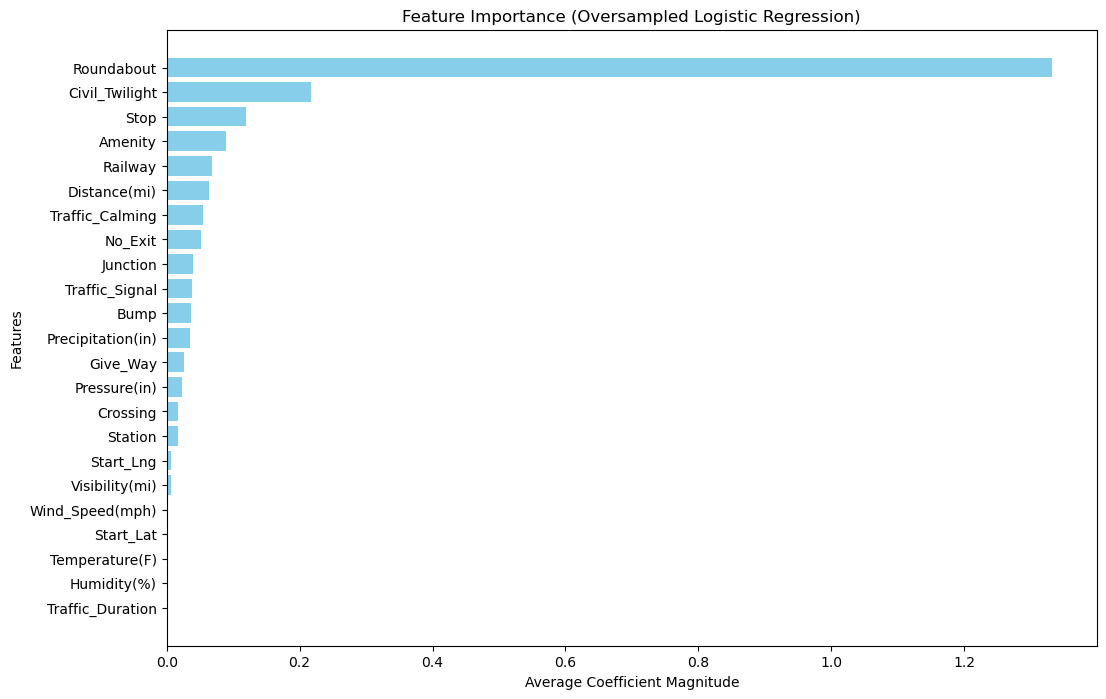

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract the coefficient matrix (for multinomial Logistic Regression)
coefficient_matrix_over = lr_model_over.coefficientMatrix.toArray()

# Compute average importance (absolute value of coefficients across classes)
average_importance_over = np.mean(np.abs(coefficient_matrix_over), axis=0)

# Map feature names to their coefficients
feature_columns = numerical_features + categorical_features
feature_importance_over = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": average_importance_over
}).sort_values(by="Importance", ascending=False)
# Plot Feature Importance for oversampled data
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_over["Feature"], feature_importance_over["Importance"], color="skyblue")
plt.title("Feature Importance (Oversampled Logistic Regression)")
plt.xlabel("Average Coefficient Magnitude")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


In [26]:
#Undersampling

In [27]:
# Filter classes
minority_class = df_prepared.filter(F.col("Severity") == 3)
majority_class = df_prepared.filter(F.col("Severity") == 2)

# Calculate undersampling fraction
undersample_fraction = minority_class.count() / majority_class.count()

# Undersample the majority class
undersampled_majority = majority_class.sample(withReplacement=False, fraction=undersample_fraction, seed=42)

# Combine undersampled majority with the minority class
df_under = undersampled_majority.union(minority_class)

# Verify class distribution
df_under.groupBy("Severity").count().show()


+--------+------+
|Severity| count|
+--------+------+
|       2|183034|
|       3|182678|
+--------+------+



In [28]:
# Split undersampled dataset into train/test sets
train_under, test_under = df_under.randomSplit([0.7, 0.3], seed=42)


In [29]:
from pyspark.ml.classification import LogisticRegression

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="final_features", labelCol="Severity", maxIter=10)
lr_model_under = lr.fit(train_under)

# Make predictions on the test set
predict_under = lr_model_under.transform(test_under)


In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy_under = evaluator.evaluate(predict_under)

print(f"Accuracy (Undersampled): {accuracy_under}")

# Generate Confusion Matrix
confusion_matrix_under = (
    predict_under.groupBy("Severity", "prediction")
    .count()
    .orderBy("Severity", "prediction")
)

# Display Confusion Matrix
confusion_matrix_under.show()


Accuracy (Undersampled): 0.6127102701320524


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0|33649|
|       2|       3.0|20896|
|       3|       2.0|21513|
|       3|       3.0|33444|
+--------+----------+-----+



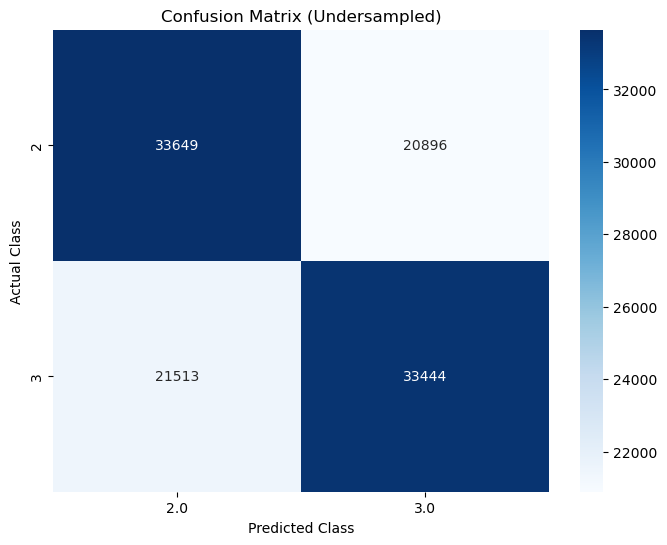

In [31]:
# Convert Confusion Matrix to Pandas
confusion_matrix_under_df = confusion_matrix_under.toPandas()

# Pivot for heatmap
pivot_under = confusion_matrix_under_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_under, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix (Undersampled)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


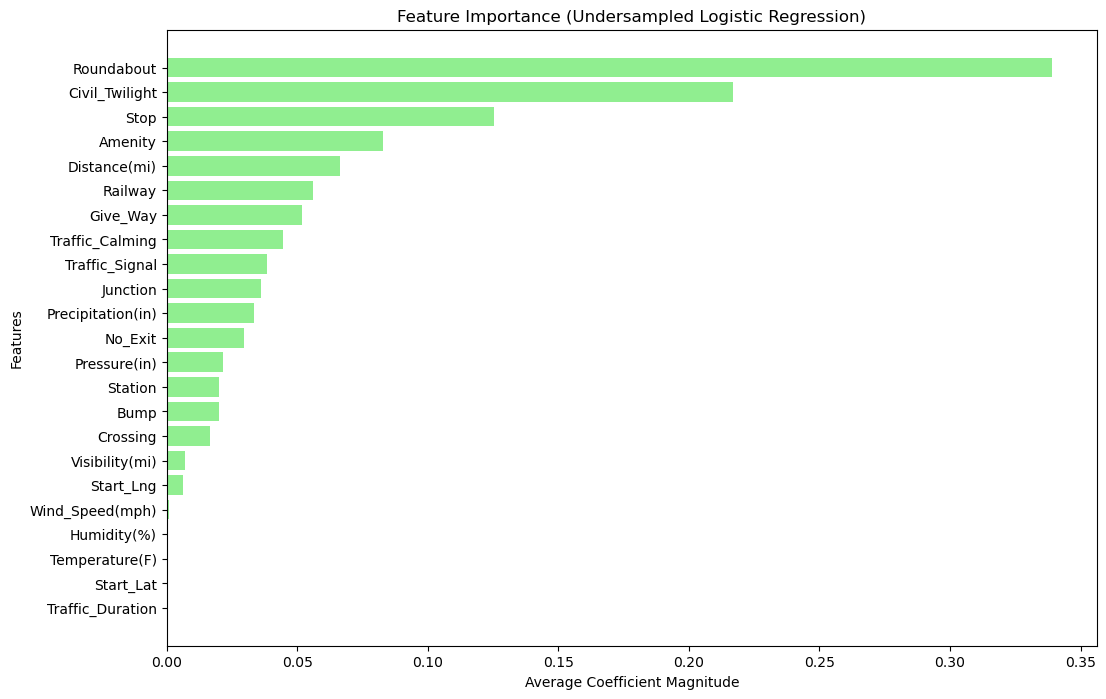

In [32]:
# Extract the coefficient matrix
coefficient_matrix_under = lr_model_under.coefficientMatrix.toArray()

# Compute average importance
average_importance_under = np.mean(np.abs(coefficient_matrix_under), axis=0)

# Map feature names to their coefficients
feature_importance_under = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": average_importance_under
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_under["Feature"], feature_importance_under["Importance"], color="lightgreen")
plt.title("Feature Importance (Undersampled Logistic Regression)")
plt.xlabel("Average Coefficient Magnitude")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()


### Evaluating Logistic Regression: Original, Oversampled, and Undersampled Datasets"

In [34]:
# Create a dictionary with accuracy scores
results = {
    "Dataset": ["Original", "Oversampled", "Undersampled"],
    "Accuracy": [accuracy, accuracy_over, accuracy_under]
}

# Convert to Pandas DataFrame for easy visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


        Dataset  Accuracy
0      Original  0.689030
1   Oversampled  0.611765
2  Undersampled  0.612710


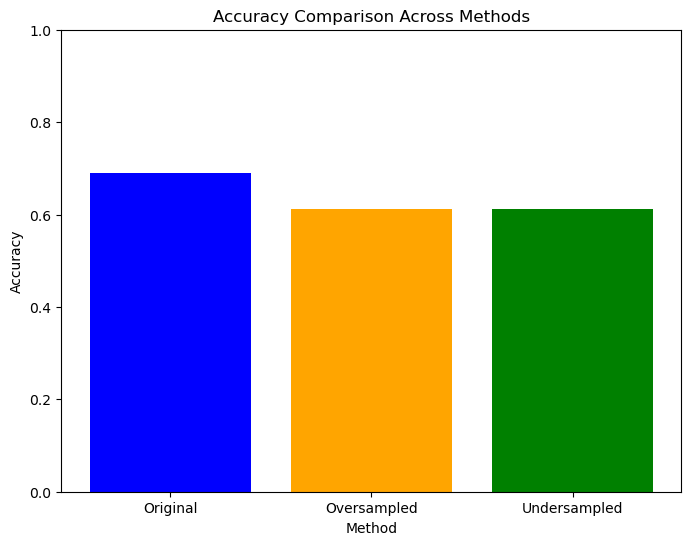

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(results_df["Dataset"], results_df["Accuracy"], color=["blue", "orange", "green"])
plt.title("Accuracy Comparison Across Methods")
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.show()


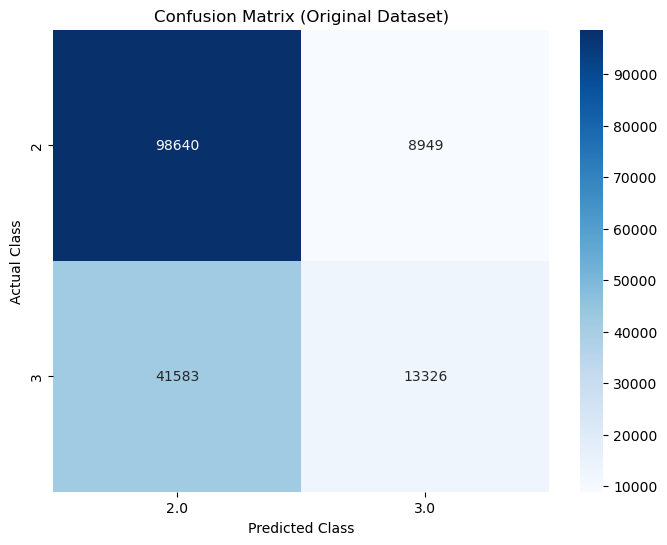

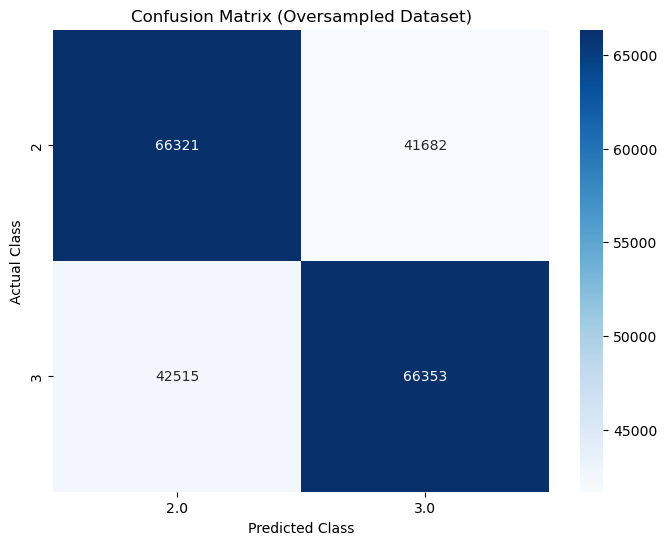

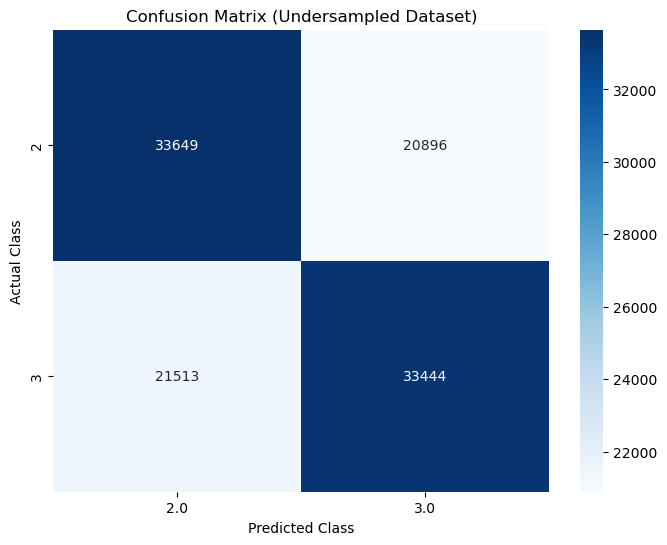

In [37]:
import seaborn as sns

# Function to plot confusion matrix heatmap
def plot_confusion_matrix(pivot, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt="g", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

# Pivot tables for confusion matrices
pivot_original = confusion_matrix_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)
pivot_over = confusion_matrix_over_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)
pivot_under = confusion_matrix_under_df.pivot(index="Severity", columns="prediction", values="count").fillna(0)

# Plot confusion matrices
plot_confusion_matrix(pivot_original, "Confusion Matrix (Original Dataset)")
plot_confusion_matrix(pivot_over, "Confusion Matrix (Oversampled Dataset)")
plot_confusion_matrix(pivot_under, "Confusion Matrix (Undersampled Dataset)")


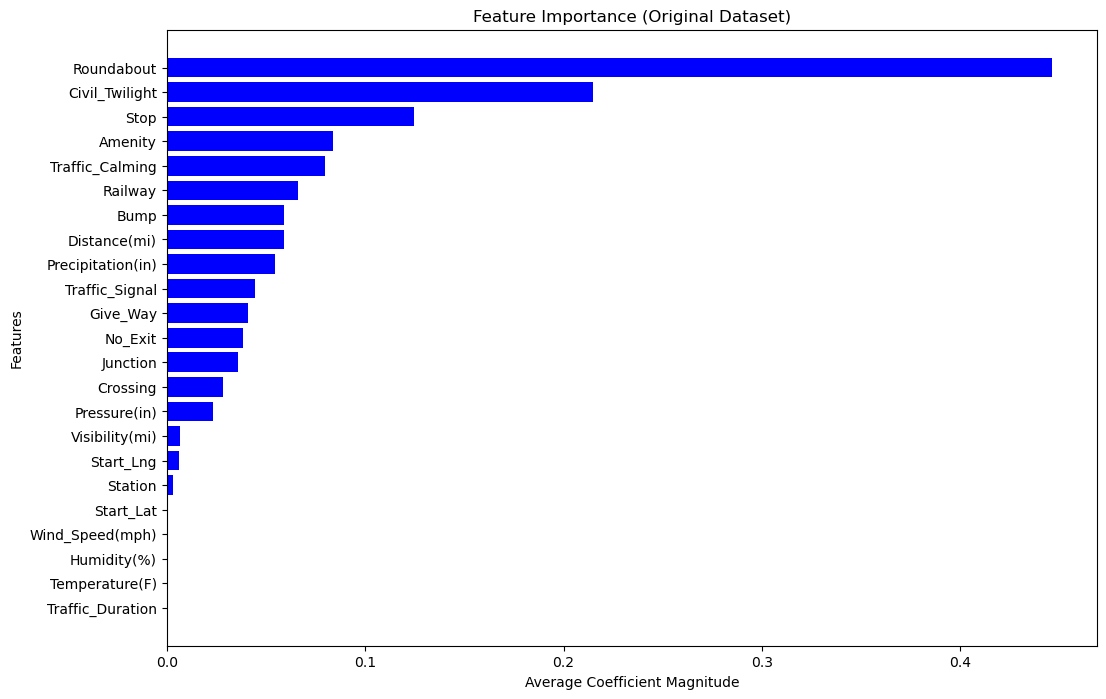

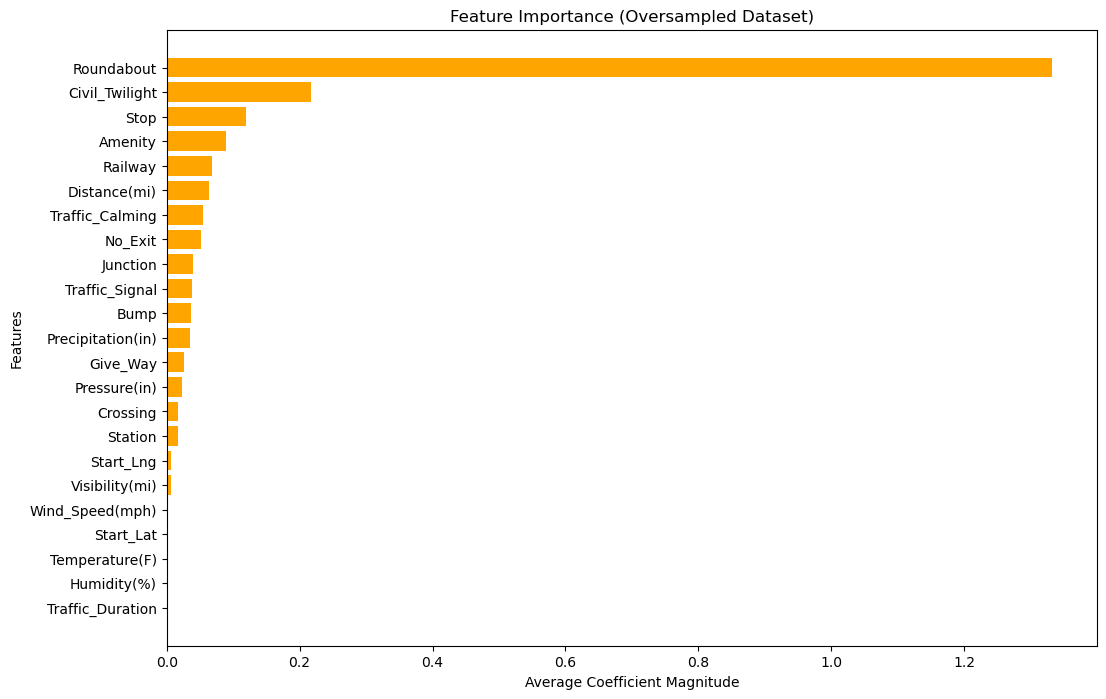

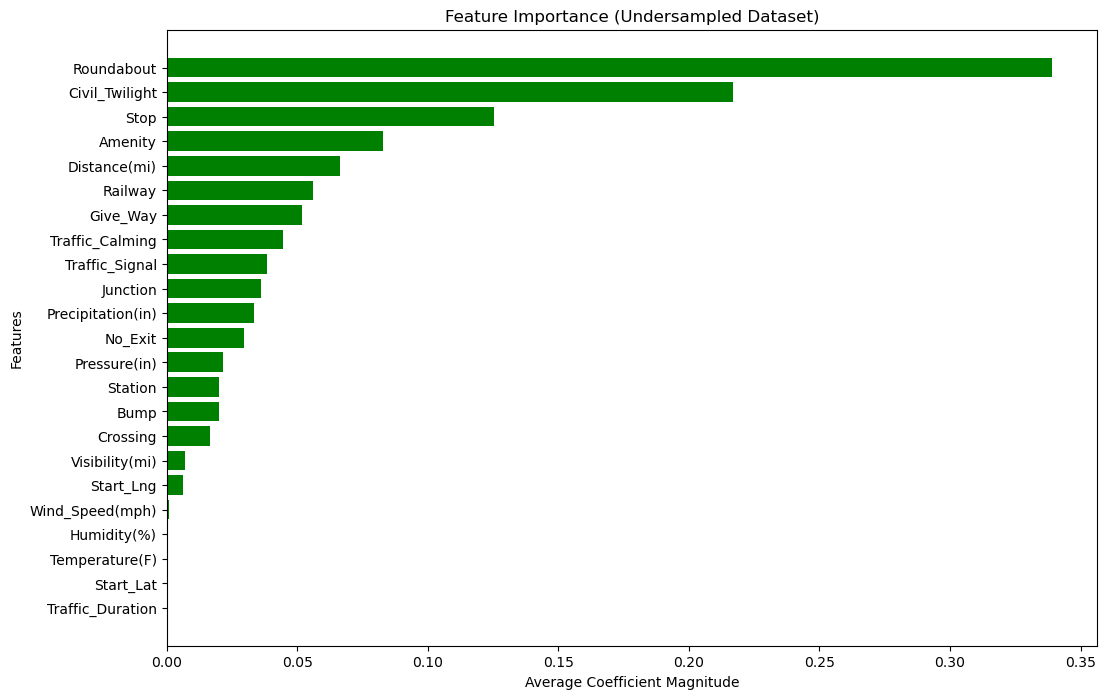

In [39]:
# Function to plot feature importance
def plot_feature_importance(feature_importance, title, color):
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance["Feature"], feature_importance["Importance"], color=color)
    plt.title(title)
    plt.xlabel("Average Coefficient Magnitude")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.show()

# Plot feature importance for each method
plot_feature_importance(feature_importance, "Feature Importance (Original Dataset)", "blue")
plot_feature_importance(feature_importance_over, "Feature Importance (Oversampled Dataset)", "orange")
plot_feature_importance(feature_importance_under, "Feature Importance (Undersampled Dataset)", "green")
